# 手写实现MLP回归器

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt	
import torch.utils.data as Data	#导入数据集
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split









In [2]:


# 加载数据集
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X = data
y = target

boston_x, boston_y = data, target	
ss = StandardScaler(with_mean=True, with_std=True)	#数据标准化处理
boston_xs = ss.fit_transform(boston_x)	# 将数据预处理为可以使用pytorch进行批量训练的形式
train_xt = torch.from_numpy(boston_xs.astype(np.float32))	# 将训练集x转化为张量，对象类型为tensor
train_yt = torch.from_numpy(boston_y.astype(np.float32))	# 将训练集y转化为张量，对象类型为tensor
train_data = Data.TensorDataset(train_xt, train_yt)

# 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset=train_data,  # 使用的数据集
    batch_size=128,  # 批处理样本大小
    shuffle=True,  # 每次迭代前打乱数据
    num_workers=0,  # 使用一个进程
)

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [3]:
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))



In [4]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation_function, optimizer, regularization, regularization_lambda):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1
        self.regularization_lambda = regularization_lambda
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.regularization = regularization
        
        # Initialize weights and biases for each layer
        self.weights = {}
        self.biases = {}
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, self.num_layers + 1):
            self.weights['W' + str(i)] = np.random.randn(layer_sizes[i - 1], layer_sizes[i]) * np.sqrt(2.0 / layer_sizes[i - 1])
            self.biases['b' + str(i)] = np.zeros((1, layer_sizes[i]))

        # Initialize optimization parameters
        if self.optimizer == 'adam':
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.m = {'W' + str(i): np.zeros_like(self.weights['W' + str(i)]) for i in range(1, self.num_layers + 1)}
            self.v = {'W' + str(i): np.zeros_like(self.weights['W' + str(i)]) for i in range(1, self.num_layers + 1)}
            self.t = 0
    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)

        
    # 省略前向传播、反向传播和激活函数部分
    def forward(self, X):
        # Forward pass
        activations = {}
        activations['a0'] = X
        for i in range(1, self.num_layers + 1):
            z = np.dot(activations['a' + str(i - 1)], self.weights['W' + str(i)]) + self.biases['b' + str(i)]
            if self.activation_function == 'relu':
                activations['a' + str(i)] = self.relu(z)
            elif self.activation_function == 'sigmoid':
                activations['a' + str(i)] = self.sigmoid(z)
            elif self.activation_function == 'tanh':
                activations['a' + str(i)] = self.tanh(z)
            
        return activations
        
    def compute_regularization(self):
        if self.regularization == 'l1':
            regularization_term = 0
            for i in range(1, self.num_layers + 1):
                regularization_term += np.sum(np.abs(self.weights['W' + str(i)]))
            return self.regularization_lambda * regularization_term
        
        elif self.regularization == 'l2':
            regularization_term = 0
            for i in range(1, self.num_layers + 1):
                regularization_term += np.sum(self.weights['W' + str(i)] ** 2)
            return 0.5 * self.regularization_lambda * regularization_term
        
        else:
            return 0
    
    def backward(self, X, y, activations, learning_rate):
        # Backpropagation
        m = X.shape[0]  # Number of examples
        
        # Compute gradients
        deltas = {}
        deltas['delta' + str(self.num_layers)] = activations['a' + str(self.num_layers)] - y
        for i in range(self.num_layers, 0, -1):
            if self.activation_function == 'relu':
                deltas['delta' + str(i - 1)] = np.dot(deltas['delta' + str(i)], self.weights['W' + str(i)].T) * (activations['a' + str(i - 1)] > 0)
            elif self.activation_function == 'sigmoid':
                deltas['delta' + str(i - 1)] = np.dot(deltas['delta' + str(i)], self.weights['W' + str(i)].T) * activations['a' + str(i - 1)] * (1 - activations['a' + str(i - 1)])
            elif self.activation_function == 'tanh':
                deltas['delta' + str(i - 1)] = np.dot(deltas['delta' + str(i)], self.weights['W' + str(i)].T) * (1 - activations['a' + str(i - 1)] ** 2)
            
        
        dWs = {}
        dbs = {}
        for i in range(1, self.num_layers + 1):
            dWs['dW' + str(i)] = (np.dot(activations['a' + str(i - 1)].T, deltas['delta' + str(i)]) + self.regularization_lambda * self.weights['W' + str(i)]) / m
            dbs['db' + str(i)] = np.sum(deltas['delta' + str(i)], axis=0, keepdims=True) / m
        
        # Add regularization term to gradients
        if self.regularization_lambda > 0:
            for i in range(1, self.num_layers + 1):
                dWs['dW' + str(i)] += self.compute_regularization()
        
        # Update weights and biases using Adam optimizer
        if self.optimizer == 'adam':
            self.t += 1
            for key in self.weights.keys():
                dW_key = 'dW' + key[1:]
                self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * dWs[dW_key]
                self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (dWs[dW_key] ** 2)
                m_hat = self.m[key] / (1 - self.beta1 ** self.t)
                v_hat = self.v[key] / (1 - self.beta2 ** self.t)
                self.weights[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.biases['b' + key[1:]] -= learning_rate * dbs['db' + key[1:]]

        
        elif self.optimizer == 'sgd':
            for key in self.weights.keys():
                dW_key = 'dW' + key[1:]
                self.weights[key] -= learning_rate * dWs[dW_key]
                self.biases['b' + key[1:]] -= learning_rate * dbs['db' + key[1:]]



In [5]:
# Initialize the model
# 定义模型参数
input_size = X_train.shape[1]
hidden_sizes = [128, 32] # 通过输入的隐藏层节点数来定义MLP层数
output_size = 1
epochs = 10000 # 训练次数
learning_rate = 0.0001 # 学习率
activation_function = 'relu' # 可以选择不同的激活函数 relu sigmoid tanh
optimizer = 'sgd' # 可以选择不同的优化器 adam sgd
regularization='l2' # 可以选择不同的正则化 l1,l2
regularization_lambda=0.001


# 初始化MLP模型
mlp = MLP(input_size, hidden_sizes, output_size, activation_function=activation_function, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# 训练循环
for epoch in range(epochs):
    # 前向传播
    activations = mlp.forward(X_train)
    
    # 计算损失（均方误差）
    loss = np.mean((activations['a' + str(mlp.num_layers)] - y_train.reshape(-1,1)) ** 2)
    
    # 打印当前损失
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss {loss}')
    
    # 反向传播更新参数
    mlp.backward(X_train, y_train.reshape(-1,1), activations, learning_rate)







Epoch 0: Loss 601.7510940187359
Epoch 100: Loss 238.89489057543
Epoch 200: Loss 88.32644165233576
Epoch 300: Loss 57.38172270887505
Epoch 400: Loss 40.90550406301772
Epoch 500: Loss 32.413949147353776
Epoch 600: Loss 28.01964825644769
Epoch 700: Loss 25.486090241372867
Epoch 800: Loss 23.790988015845105
Epoch 900: Loss 22.516521889686743
Epoch 1000: Loss 21.47730243668199
Epoch 1100: Loss 20.59264390466055
Epoch 1200: Loss 19.825563790090843
Epoch 1300: Loss 19.15181508610369
Epoch 1400: Loss 18.55090600482005
Epoch 1500: Loss 18.00396408136423
Epoch 1600: Loss 17.50677190435322
Epoch 1700: Loss 17.047493496880044
Epoch 1800: Loss 16.63201806885181
Epoch 1900: Loss 16.261130218059854
Epoch 2000: Loss 15.92379653586994
Epoch 2100: Loss 15.611010232178236
Epoch 2200: Loss 15.323788978416593
Epoch 2300: Loss 15.058639689422964
Epoch 2400: Loss 14.81250553202238
Epoch 2500: Loss 14.582192351926347
Epoch 2600: Loss 14.364620421442382
Epoch 2700: Loss 14.15710056065396
Epoch 2800: Loss 13.95

MAE: 2.2215698948358913


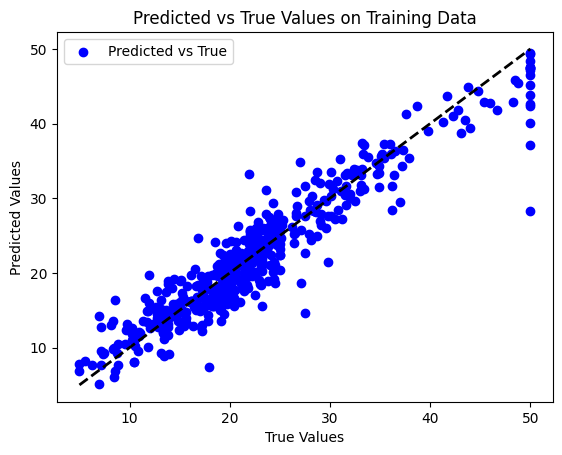

In [6]:
true_train = target
# 获取训练数据的预测值
train_data_tensor = train_data.tensors[0]
# Forward pass
output = mlp.forward(train_data_tensor)
# print(output['a3'])

# Flatten predictions and convert to Python list
predictions = output['a3'].flatten().tolist()



plt.figure()
plt.scatter(true_train, predictions, color='blue', label='Predicted vs True')
plt.plot([true_train.min(), true_train.max()], [true_train.min(), true_train.max()], 'k--', lw=2)  # 绘制对角线
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values on Training Data')
plt.legend()
MAE = mae(true_train, predictions)
print("MAE:", MAE)